In [3]:
from tqdm import tqdm
def estimate_rho_nu(window_data):
    try:
        rho, nu, _ = fit_t_copula(window_data)
        return rho, nu if 2 <= nu <= 30 else 10  # Limiter nu entre 2 et 30
    except Exception as e:
        print(f"Erreur lors de l'estimation : {e}")
        rho = np.corrcoef(window_data[:, 0], window_data[:, 1])[0, 1]
        return rho, 10  # Valeur par défaut pour nu

# Télécharger les données historiques de SPY et FCHI
print("Téléchargement des données historiques...")
spy = yf.download("^GSPC", start="2005-01-01")["Close"]
fchi = yf.download("^FCHI", start="2005-01-01")["Close"]


data = pd.concat([spy, fchi], axis=1).dropna()
data.columns = ["^GSPC", "^FCHI"]

# Calculer les rendements et volatilités
data["r_spy"] = np.log(data["^GSPC"] / data["^GSPC"].shift(1))
data["r_fchi"] = np.log(data["^FCHI"] / data["^FCHI"].shift(1))
data["vol_spy"] = data["r_spy"].rolling(window=20).std()
data["vol_fchi"] = data["r_fchi"].rolling(window=20).std()
from scipy.stats import skew, kurtosis
data["skew_spy"] = data["r_spy"].rolling(window=30).apply(lambda x: skew(x))
data["kurt_spy"] = data["r_spy"].rolling(window=30).apply(lambda x: kurtosis(x))
data["skew_fchi"] = data["r_fchi"].rolling(window=30).apply(lambda x: skew(x))
data["kurt_fchi"] = data["r_fchi"].rolling(window=30).apply(lambda x: kurtosis(x))
# Télécharger les taux swap IRS à 1 an

data = data.dropna()

# Transformer en uniformes (comme dans l'image)
data["u_spy"] = data["r_spy"].rank() / (len(data["r_spy"]) + 1)
data["u_fchi"] = data["r_fchi"].rank() / (len(data["r_spy"]) + 1)

# Calculer rho_t et nu_t sur des fenêtres roulantes
window_size = 100
rho_targets = []
nu_targets = []
print(f"Calcul des paramètres rho_t et nu_t sur fenêtres de {window_size} jours...")
for i in tqdm(range(window_size, len(data))):
    window = data[["u_spy", "u_fchi"]].iloc[i - window_size:i].values
    rho_t, nu_t = estimate_rho_nu(window)
    rho_targets.append(rho_t)
    nu_targets.append(nu_t)

# Préparer les données avec lags
X = data[["r_spy", "r_fchi", "vol_spy", "vol_fchi","skew_spy","kurt_spy","skew_fchi","kurt_fchi"]].values[window_size:]
y_nu = np.array(nu_targets)
y_rho = np.array(rho_targets)
y_nu_clean = [x for x in y_nu if not np.isnan(x) and 2 <= x <= 30]
valid_indices = [i for i, x in enumerate(y_nu) if not np.isnan(x) and 2 <= x <= 30]
X_clean = X[valid_indices]
y_rho_clean = [y_rho[i] for i in valid_indices]

nu_series = pd.Series(y_nu_clean)
rho_series = pd.Series(y_rho_clean)
for lag in range(1, 4):
    X_clean = np.hstack((X_clean, nu_series.shift(lag).values.reshape(-1, 1)[valid_indices]))
    X_clean = np.hstack((X_clean, rho_series.shift(lag).values.reshape(-1, 1)[valid_indices]))
X_clean = X_clean[3:]
y_nu_clean = y_nu_clean[3:]
y_rho_clean = y_rho_clean[3:]
y_clean = np.vstack((y_nu_clean, y_rho_clean)).T

# Normaliser les données
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_clean)

# Créer des séquences temporelles
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X_seq, y_seq = create_sequences(X_scaled, y_clean, seq_length)

# Diviser en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

Téléchargement des données historiques...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Calcul des paramètres rho_t et nu_t sur fenêtres de 100 jours...


100%|██████████| 4918/4918 [2:27:35<00:00,  1.80s/it]  


In [ ]:
from scipy.optimize import minimize
from scipy.special import gamma

def t_copula_density(u1, u2, rho, nu):
    """
    Calcule la densité de la copule t pour une paire (u1, u2).
    """
    # Transformer u1 et u2 en quantiles t
    z1 = t.ppf(u1, df=nu)
    z2 = t.ppf(u2, df=nu)
    
    # Densité jointe de la distribution t bivariée
    cov = np.array([[1, rho], [rho, 1]])
    det = 1 - rho**2
    inv_cov = np.linalg.inv(cov)
    z = np.array([z1, z2])
    mahalanobis = np.dot(z, np.dot(inv_cov, z))
    const = gamma((nu + 2) / 2) / (gamma(nu / 2) * nu * np.pi * np.sqrt(det))
    pdf_joint = const * (1 + mahalanobis / nu) ** (-(nu + 2) / 2)
    
    # Densités marginales
    pdf_marg1 = t.pdf(z1, df=nu)
    pdf_marg2 = t.pdf(z2, df=nu)
    
    # Densité de la copule
    c = pdf_joint / (pdf_marg1 * pdf_marg2) if pdf_marg1 * pdf_marg2 > 0 else 1e-10
    return c

def log_likelihood(params, data):
    """
    Calcule la log-vraisemblance négative pour la copule t.
    """
    rho, nu = params
    if nu <= 2 or abs(rho) >= 1:  # Pénalité pour valeurs invalides
        return np.inf
    u1, u2 = data[:, 0], data[:, 1]
    u1 = np.clip(u1, 1e-10, 1 - 1e-10)  # Éviter les valeurs extrêmes
    u2 = np.clip(u2, 1e-10, 1 - 1e-10)
    densities = [t_copula_density(u1[i], u2[i], rho, nu) for i in range(len(u1))]
    densities = np.clip(densities, 1e-10, np.inf)
    return -np.sum(np.log(densities))  # Négatif pour minimisation

def fit_t_copula(data):
    """
    Estime rigoureusement rho et nu d'une copule t bivariée.
    
    Paramètres :
    - data : ndarray (n, 2) avec variables uniformes u1 et u2.
    
    Retourne :
    - rho : corrélation estimée.
    - nu : degrés de liberté estimés.
    - ll : log-vraisemblance maximale.
    """
    # Initialisation
    rho_init = np.corrcoef(data[:, 0], data[:, 1])[0, 1]
    nu_init = 10
    
    # Bornes pour l'optimisation
    bounds = [(-0.99, 0.99), (2.01, 30)]
    
    # Optimisation
    result = minimize(log_likelihood, [rho_init, nu_init], args=(data,), 
                      bounds=bounds, method='L-BFGS-B')
    
    if result.success:
        rho, nu = result.x
        ll = -result.fun
    else:
        rho, nu = rho_init, nu_init
        ll = -log_likelihood([rho, nu], data)
    
    return rho, nu, ll

Construction et entraînement du modèle Transformer...
Epoch 1/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 46.0807 - val_loss: 43.3931
Epoch 2/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 35.2579 - val_loss: 36.4881
Epoch 3/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 32.2491 - val_loss: 31.4544
Epoch 4/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 27.6641 - val_loss: 27.9281
Epoch 5/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 23.7188 - val_loss: 24.3867
Epoch 6/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 20.7033 - val_loss: 18.8802
Epoch 7/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 17.5670 - val_loss: 14.8904
Epoch 8/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 13.1201 - val_loss: 11.9295
Epoch 9/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 10.7244 - val_loss: 9.4573
Epoch 10/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.4236 - val_loss: 8.6812
Epoch 11/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.5210 - val_loss:

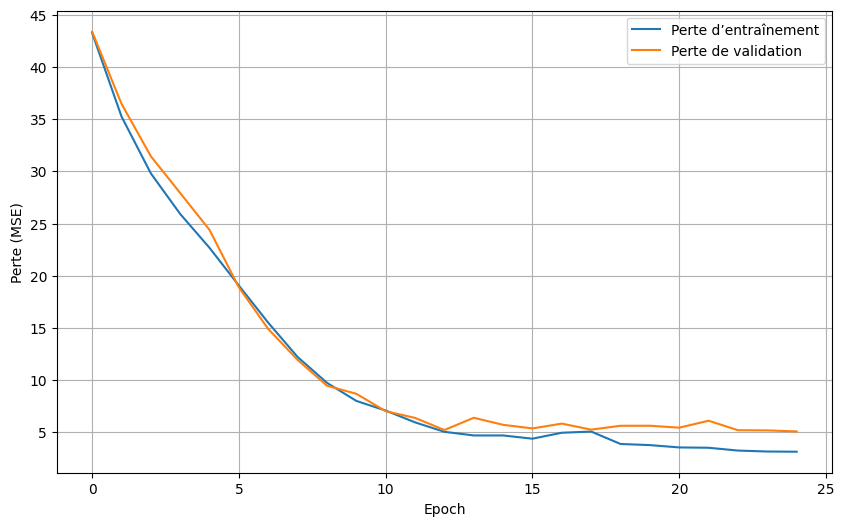

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MSE pour nu_t : 9.651749272080467
MSE pour rho_t : 0.009378891262820968


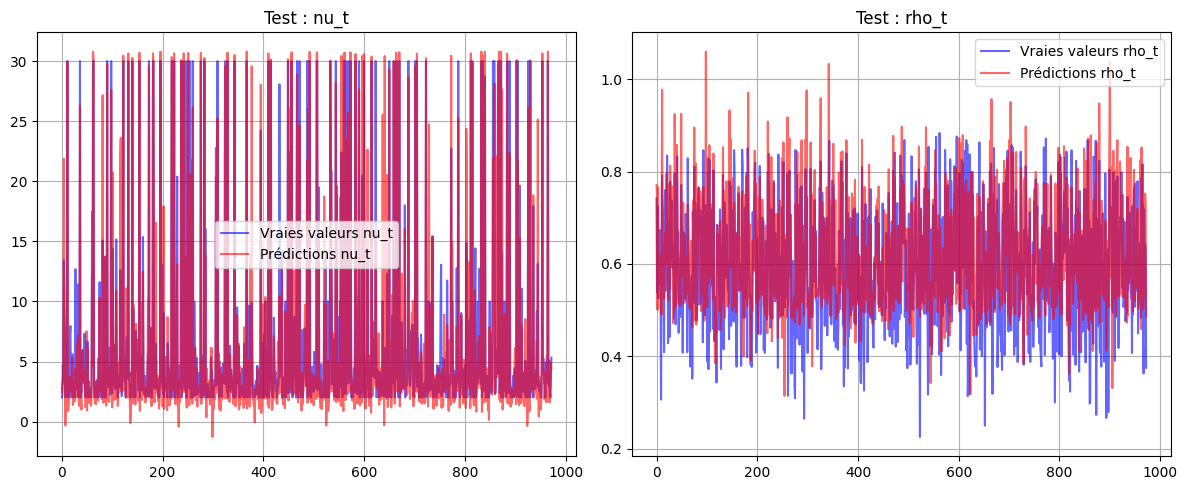

In [ ]:

# Définir le modèle Transformer
def build_transformer(input_shape, num_heads=8, d_model=64, dff=512, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    x = inputs
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    x = LayerNormalization(epsilon=1e-5)(x + attn_output)
    ffn = Dense(dff, activation='relu')(x)
    ffn = Dense(input_shape[1])(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    x = LayerNormalization(epsilon=1e-6)(x + ffn)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(2)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Entraîner le modèle
print("Construction et entraînement du modèle Transformer...")
model = build_transformer((seq_length, X_scaled.shape[1]))
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.3, verbose=1)

# Visualiser la perte
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perte d’entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Évolution de la perte pendant l’entraînement')
plt.xlabel('Epoch')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Faire des prédictions
predictions = model.predict(X_test)
nu_pred = predictions[:, 0]
rho_pred = predictions[:, 1]
nu_true = y_test[:, 0]
rho_true = y_test[:, 1]

mse_nu = mean_squared_error(nu_true, nu_pred)
mse_rho = mean_squared_error(rho_true, rho_pred)
print(f"MSE pour nu_t : {mse_nu}")
print(f"MSE pour rho_t : {mse_rho}")

# Visualiser les prédictions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(nu_true, label='Vraies valeurs nu_t', color='blue', alpha=0.6)
plt.plot(nu_pred, label='Prédictions nu_t', color='red', alpha=0.6)
plt.title('Test : nu_t')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(rho_true, label='Vraies valeurs rho_t', color='blue', alpha=0.6)
plt.plot(rho_pred, label='Prédictions rho_t', color='red', alpha=0.6)
plt.title('Test : rho_t')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()